In [19]:
pip install openai pandas numpy scikit-learn matplotlib


In [20]:
import os, time, math, random, json, pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from openai import OpenAI
import random, numpy as np, os
random.seed(42)
np.random.seed(42)

MODEL_NAME = "text-embedding-ada-002"
BATCH_SIZE = 8
BACKOFF_FACTOR = 0.6
MAX_RETRIES = 6
THRESHOLD = 0.7


In [21]:
os.environ["OPENAI_API_KEY"] = "sk-paste_your_api_key"
client = OpenAI(api_key=os.environ["OPENAI_API_KEY"])

products = [
    {"id": 1, "name": "Boho Breeze Dress", "desc": "Flowy maxi dress, earthy tones, embroidered details perfect for festival and beach vibes.", "tags": ["boho","flowy","festival"], "popularity": 0.6},
    {"id": 2, "name": "Urban Pulse Jacket", "desc": "Structured bomber jacket with reflective trims and bold silhouette; energetic urban chic.", "tags": ["urban","chic","energetic"], "popularity": 0.9},
    {"id": 3, "name": "Minimal Office Shirt", "desc": "Crisp tailored shirt, neutral palette, clean lines ideal for minimal professional looks.", "tags": ["minimal","office","formal"], "popularity": 0.7},
    {"id": 4, "name": "Cozy Knit Sweater", "desc": "Chunky knit, soft yarn, relaxed fit cozy warm weekend-casual comfort.", "tags": ["cozy","casual","warm"], "popularity": 0.65},
    {"id": 5, "name": "Athleisure Runner Tee", "desc": "Lightweight breathable tee with stretch sporty energetic for active city life.", "tags": ["sporty","athleisure","energetic"], "popularity": 0.75},
    {"id": 6, "name": "Vintage Denim Skirt", "desc": "High-waist denim skirt with retro wash playful casual slightly nostalgic.", "tags": ["vintage","casual","playful"], "popularity": 0.5},
    {"id": 7, "name": "Silk Evening Gown", "desc": "Sleek silk gown with minimalist cut premium elegant eveningwear.", "tags": ["elegant","evening","premium"], "popularity": 0.85},
    {"id": 8, "name": "Street Canvas Sneakers", "desc": "Bold sole canvas sneakers with graphic details streetwear-ready energetic.", "tags": ["streetwear","sneakers","urban"], "popularity": 0.8}
]

df = pd.DataFrame(products)
if "popularity" not in df.columns:
    df["popularity"] = 0.5
df["popularity"] = df["popularity"].fillna(0.5)

df["embed_text"] = df["name"] + ". " + df["desc"] + " Tags: " + df["tags"].apply(lambda t: " ".join(t))
vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=1)
tfidf_embeddings = vectorizer.fit_transform(df["embed_text"]).toarray()

if "popularity" not in df.columns:
    df["popularity"] = 0.5
df["popularity"] = df["popularity"].fillna(0.5)

df["embed_text"] = df["name"] + ". " + df["desc"] + " Tags: " + df["tags"].apply(lambda t: " ".join(t))
vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=1)
tfidf_embeddings = vectorizer.fit_transform(df["embed_text"]).toarray()

In [22]:
def get_embeddings_openai(texts, model="text-embedding-ada-002", batch_size=8, max_retries=6, backoff_factor=0.6):
    all_embs = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        for attempt in range(max_retries):
            try:
                res = client.embeddings.create(model=model, input=batch)
                batch_embs = [r.embedding for r in res.data]
                all_embs.extend(batch_embs)
                time.sleep(0.06)
                break
            except Exception as e:
                wait = (2 ** attempt) * backoff_factor + random.random() * 0.1
                time.sleep(wait)
                if attempt == max_retries - 1:
                    raise
    return np.array(all_embs)

def safe_get_embeddings(texts):
    try:
        return get_embeddings_openai(texts)
    except Exception:
        return vectorizer.transform(texts).toarray()

product_embeddings = safe_get_embeddings(df["embed_text"].tolist())
if product_embeddings.shape[0] != df.shape[0]:
    product_embeddings = tfidf_embeddings


In [23]:
def tag_overlap_score(query_tags, prod_tags):
    if not query_tags:
        return 0.0
    overlap = set(query_tags).intersection(set(prod_tags))
    return len(overlap) / max(len(set(query_tags)), 1)

def extract_query_tags(query):
    q = query.lower()
    found = []
    for tag in sorted({t for tags in df["tags"] for t in tags}, key=len, reverse=True):
        if tag in q:
            found.append(tag)
    return found

def rerank(results, query, alpha=0.75, beta=0.15, gamma=0.10):
    qtags = extract_query_tags(query)
    pop_vals = np.array(df["popularity"].tolist(), dtype=float)
    pop_min, pop_max = pop_vals.min(), pop_vals.max()
    pop_norm = (pop_vals - pop_min) / (pop_max - pop_min + 1e-9)
    id_to_pop = {int(df.loc[i,"id"]): float(pop_norm[i]) for i in range(len(df))}
    for r in results:
        tag_score = tag_overlap_score(qtags, r["tags"])
        pop_score = id_to_pop.get(r["id"], 0.0)
        r["final_score"] = alpha * r["score"] + beta * tag_score + gamma * pop_score
    return sorted(results, key=lambda x: x["final_score"], reverse=True)



Query: energetic urban chic
 - Urban Pulse Jacket -- emb_score:0.8652 final_score:0.8989
 - Street Canvas Sneakers -- emb_score:0.8324 final_score:0.7493
 - Athleisure Runner Tee -- emb_score:0.8392 final_score:0.7419
 - Silk Evening Gown -- emb_score:0.7746 final_score:0.6684
 - Minimal Office Shirt -- emb_score:0.7859 final_score:0.6394
Latency: 0.668s

Query: cozy boho weekend
 - Cozy Knit Sweater -- emb_score:0.8447 final_score:0.7461
 - Boho Breeze Dress -- emb_score:0.8347 final_score:0.7260
 - Urban Pulse Jacket -- emb_score:0.7725 final_score:0.6794
 - Silk Evening Gown -- emb_score:0.7658 final_score:0.6618
 - Street Canvas Sneakers -- emb_score:0.7733 final_score:0.6550
Latency: 1.137s

Query: minimal office wear
 - Minimal Office Shirt -- emb_score:0.8620 final_score:0.8465
 - Urban Pulse Jacket -- emb_score:0.7698 final_score:0.6774
 - Silk Evening Gown -- emb_score:0.7775 final_score:0.6707
 - Street Canvas Sneakers -- emb_score:0.7771 final_score:0.6578
 - Athleisure Run

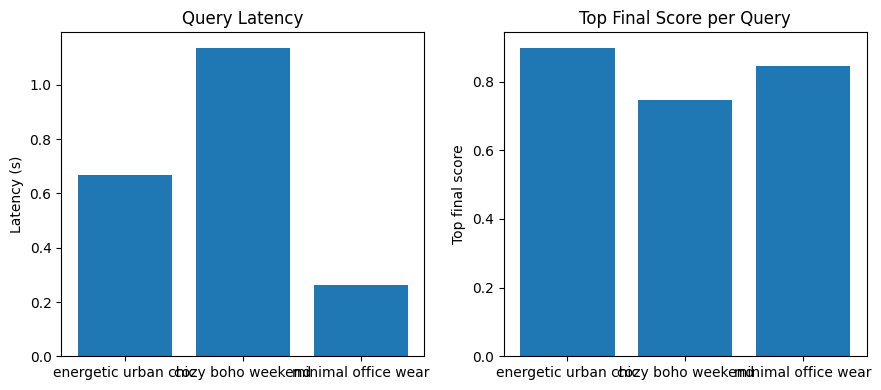

In [24]:
def match_products(query, top_k=3, threshold=0.7, rerank_weights=(0.75,0.15,0.10)):
    start = time.perf_counter()
    q_emb = safe_get_embeddings([query])[0].reshape(1, -1)
    sims = cosine_similarity(q_emb, product_embeddings)[0]
    results = []
    for i, s in enumerate(sims):
        results.append({"id": int(df.loc[i,"id"]), "name": df.loc[i,"name"], "score": float(s), "desc": df.loc[i,"desc"], "tags": df.loc[i,"tags"]})
    results_sorted = sorted(results, key=lambda x: x["score"], reverse=True)
    results_reranked = rerank(results_sorted, query, alpha=rerank_weights[0], beta=rerank_weights[1], gamma=rerank_weights[2])
    top_results = results_reranked[:top_k]
    latency = time.perf_counter() - start
    fallback = None
    if top_results[0]["final_score"] < threshold:
        fallback = {"message": f"No confident match found (top final score {top_results[0]['final_score']:.3f} < {threshold}).", "suggested": ["casual weekend vibe","elegant evening look","sporty city outfit"]}
    return {"query": query, "results": top_results, "latency_s": latency, "fallback": fallback}

queries = ["energetic urban chic", "cozy boho weekend", "minimal office wear"]
runs = []
good_count = 0
for q in queries:
    out = match_products(q, top_k=5, threshold=0.7)
    runs.append(out)
    top_final = out["results"][0]["final_score"]
    if top_final >= 0.7:
        good_count += 1
    print("\nQuery:", q)
    for r in out["results"]:
        print(f" - {r['name']} -- emb_score:{r['score']:.4f} final_score:{r['final_score']:.4f}")
    if out["fallback"]:
        print(out["fallback"]["message"])
        print("Suggestions:", ", ".join(out["fallback"]["suggested"]))
    print("Latency: {:.3f}s".format(out["latency_s"]))

def compute_metrics(runs, rel_threshold=0.7):
    p1 = 0
    rr_sum = 0.0
    avg_top_scores = []
    prec_at_k = {1:0,3:0,5:0}
    for run in runs:
        top_final = run["results"][0]["final_score"]
        avg_top_scores.append(top_final)
        if top_final >= rel_threshold:
            p1 += 1
        rr = 0.0
        for i, r in enumerate(run["results"], start=1):
            if r["final_score"] >= rel_threshold:
                rr = 1.0 / i
                break
        rr_sum += rr
        for k in prec_at_k.keys():
            hits = sum(1 for r in run["results"][:k] if r["final_score"] >= rel_threshold)
            prec_at_k[k] += hits / k
    n = len(runs)
    return {"precision@1": p1/n, "MRR": rr_sum/n, "avg_top_final_score": sum(avg_top_scores)/n, "precision@k": {k: prec_at_k[k]/n for k in prec_at_k}}

metrics_07 = compute_metrics(runs, rel_threshold=0.7)
metrics_06 = compute_metrics(runs, rel_threshold=0.6)
print("\nMetrics (threshold 0.7):", metrics_07)
print("Metrics (threshold 0.6):", metrics_06)
print(f"\nGood matches (>0.7): {sum(1 for r in runs if r['results'][0]['final_score']>=0.7)}/{len(runs)}")

rows = []
for run in runs:
    for rank, r in enumerate(run["results"], start=1):
        rows.append({"query": run["query"], "rank": rank, "product_id": r["id"], "product_name": r["name"], "emb_score": r["score"], "final_score": r["final_score"], "latency_s": run["latency_s"], "fallback": bool(run["fallback"])})
log_df = pd.DataFrame(rows)
log_df.to_csv("vibe_matcher_results_enhanced.csv", index=False)
print("\nSaved vibe_matcher_results_enhanced.csv")

latencies = [r["latency_s"] for r in runs]
avg_finals = [r["results"][0]["final_score"] for r in runs]
plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
plt.bar([r["query"] for r in runs], latencies)
plt.ylabel("Latency (s)")
plt.title("Query Latency")
plt.subplot(1,2,2)
plt.bar([r["query"] for r in runs], avg_finals)
plt.ylabel("Top final score")
plt.title("Top Final Score per Query")
plt.tight_layout()
plt.show()


In [25]:
intro = "Nexora can leverage AI-driven semantic matching to convert short human 'vibe' queries into product recommendations, improving discovery and conversion by matching mood-driven intent to product descriptions and signals."
print("\nIntro for deliverable:\n", intro)

improvements = [
    "Use a dedicated vector DB (Pinecone/Weaviate/FAISS) with ANN for scalability and latency improvements.",
    "Gather human judgments to tune threshold and perform A/B tests for threshold-driven UX decisions.",
    "Add multimodal embeddings (image + text) for richer vibe matching when product photos are available.",
    "Implement online learning with user feedback to adapt ranking weights and improve accuracy over time."
]
print("\nSuggested improvements:")
for it in improvements:
    print(" -", it)


Intro for deliverable:
 Nexora can leverage AI-driven semantic matching to convert short human 'vibe' queries into product recommendations, improving discovery and conversion by matching mood-driven intent to product descriptions and signals.

Suggested improvements:
 - Use a dedicated vector DB (Pinecone/Weaviate/FAISS) with ANN for scalability and latency improvements.
 - Gather human judgments to tune threshold and perform A/B tests for threshold-driven UX decisions.
 - Add multimodal embeddings (image + text) for richer vibe matching when product photos are available.
 - Implement online learning with user feedback to adapt ranking weights and improve accuracy over time.


# New Section